# Prepare Required Files and Dependencies

In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.


In [2]:
from os import listdir
from os.path import isfile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint

from utils import *

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [4]:
img_path = "datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames[:20])

['frog.bmp', 'FOOTBALL.BMP', 'WALL.BMP', 'rooster.bmp', 'man.bmp', 'BEACH.BMP', 'airplane.bmp', 'hawaii.bmp', 'rabbits.bmp', '1fnoise.bmp', 'pelicans.bmp', 'baby.bmp', 'TABLE.BMP', 'valley.bmp', 'tank.bmp', 'baboon.bmp', 'kid.bmp', 'lily.bmp', 'bushes.bmp', 'branches.bmp', 'tulips.bmp', 'fox.bmp', 'birds.bmp', 'peppers.bmp', 'buds.bmp', 'bricks.bmp', 'FLOWERS.BMP', 'deer.bmp', 'fruits.bmp', 'desert.bmp', 'duck.bmp', 'horse.bmp', 'lena.bmp', 'sealion.bmp', 'TRAIN.BMP', 'helen.bmp', 'rainriver.bmp', 'stream.bmp', 'bark.bmp', 'SAIL.BMP', 'HOUSE.BMP', 'peak.bmp', 'PUMPKINS.BMP', 'barn.bmp', 'pony.bmp', 'bridge.bmp', 'eagle.bmp', 'barbara.bmp', 'beans.bmp', 'dune2.bmp', 'zelda.bmp', 'KIDS.BMP', 'cactus.bmp', 'sheep.bmp']


In [5]:
image_patches = []
targets = []

for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    for i in range(0, img.shape[0], BLOCK_SIZE):
        for j in range(0, img.shape[1], BLOCK_SIZE):
            patch = img[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE]
            targets.append(patch[3:5, 3:5].flatten())

            patch[3:5, 3:5] = 0.0
            image_patches.append(patch)

In [6]:
X_train = np.array(image_patches) / 255.0
y_train = np.array(targets) / 255.0

In [7]:
X_train = X_train.reshape(-1, BLOCK_SIZE, BLOCK_SIZE, 1)

# Modeling

In [8]:
model_fname = "models/model.cnn.h5"

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(BLOCK_SIZE, BLOCK_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_OUT_NODES, activation='sigmoid')
])

model.compile(loss="mean_squared_error", optimizer="adam",
                metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 32)          832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

2023-07-19 20:20:03.406663: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-19 20:20:03.406683: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-19 20:20:03.406686: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-19 20:20:03.406713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-19 20:20:03.406726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, batch_size=256,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450


2023-07-19 20:20:03.766089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


195/195 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.3367
Epoch 1: loss improved from inf to 0.01242, saving model to models/model.cnn.h5
195/195 [==============================] - 2s 8ms/step - loss: 0.0124 - accuracy: 0.3367 - val_loss: 0.0067 - val_accuracy: 0.3846
Epoch 2/450
  1/195 [..............................] - ETA: 1s - loss: 0.0032 - accuracy: 0.4141

2023-07-19 20:20:05.548736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/195 [===========================>..] - ETA: 0s - loss: 0.0042 - accuracy: 0.4115
Epoch 2: loss improved from 0.01242 to 0.00416, saving model to models/model.cnn.h5
195/195 [==============================] - 1s 6ms/step - loss: 0.0042 - accuracy: 0.4108 - val_loss: 0.0065 - val_accuracy: 0.3910
Epoch 3/450
189/195 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.4284
Epoch 3: loss improved from 0.00416 to 0.00379, saving model to models/model.cnn.h5
195/195 [==============================] - 1s 6ms/step - loss: 0.0038 - accuracy: 0.4291 - val_loss: 0.0064 - val_accuracy: 0.3895
Epoch 4/450
193/195 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.4417
Epoch 4: loss improved from 0.00379 to 0.00363, saving model to models/model.cnn.h5
195/195 [==============================] - 1s 6ms/step - loss: 0.0036 - accuracy: 0.4421 - val_loss: 0.0063 - val_accuracy: 0.4394
Epoch 5/450
190/195 [============================>.] - ETA: 0s - loss: 0.003

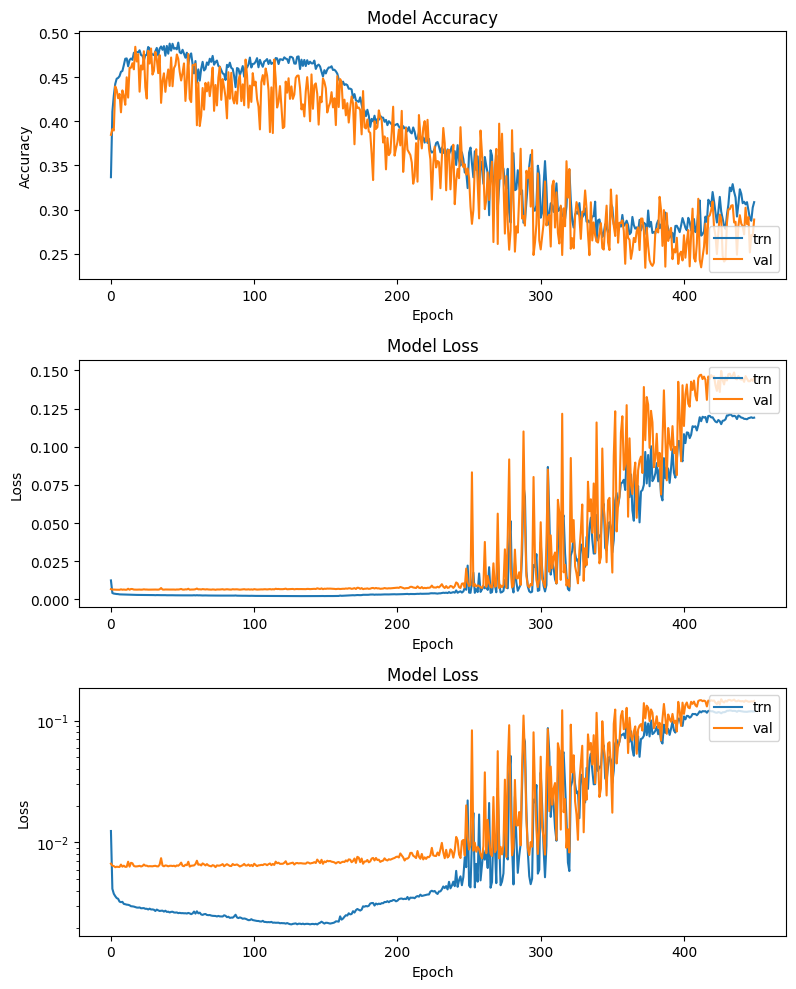

In [10]:
plot_training_history(history)

32/32 [==============================] - 0s 2ms/step
MSE = 127.00


2023-07-19 20:28:36.311218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


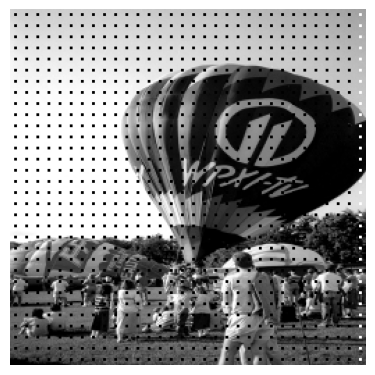

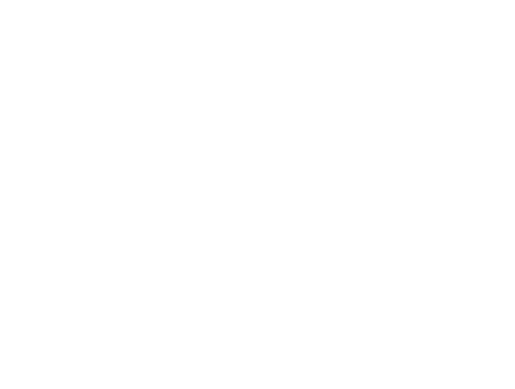

In [11]:
evaluate_cnn(model)